In [2]:
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse
from annoy import AnnoyIndex

%matplotlib inline

In [235]:
from sklearn.metrics import mean_squared_error


def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [228]:
# df = pd.read_csv('yelp/review_matrix.csv', header=None, names=['user_id', 'business_id', 'rating'])
df = pd.read_csv('orgs.csv', encoding='utf-8')

In [229]:
from collections import defaultdict

org_id_to_name = dict(zip(df['org_id'], df['org_name']))
org_name_to_ids = defaultdict(list)
for _org_id, _org_name in org_id_to_name.items():
    org_name_to_ids[_org_name].append(_org_id)
org_id_to_unique_name = {}
for _org_name, _org_ids in org_name_to_ids.items():
    if len(_org_ids) == 1:
        org_id_to_unique_name[_org_ids[0]] = _org_name
    else:
        for i, _org_id in enumerate(_org_ids, start=1):
            org_id_to_unique_name[_org_id] = f'{_org_name} ({i})'

In [230]:
df['unique_name'] = list(map(org_id_to_unique_name.get, df.org_id))

In [231]:
df['binary_rating'] = (df['rating'] >= 4).astype(int)

In [233]:
df.head()

,org_id,user_id,rating,org_name,user_name,text,unique_name,binary_rating
0,ChIJV2V2Ew9LtUYRzMPrmUTvkyk,109475426397838203565,5,Onebucks Сoffee,Елена Луненок,NaN,Onebucks Сoffee (1),1
1,ChIJV2V2Ew9LtUYRzMPrmUTvkyk,104454704917743395776,5,Onebucks Сoffee,Isankoulov,NaN,Onebucks Сoffee (1),1
2,ChIJV2V2Ew9LtUYRzMPrmUTvkyk,107100762489312073701,5,Onebucks Сoffee,Еlena Pavlova,NaN,Onebucks Сoffee (1),1
3,ChIJV2V2Ew9LtUYRzMPrmUTvkyk,114074890317637913080,3,Onebucks Сoffee,Roman K.,NaN,Onebucks Сoffee (1),0
4,ChIJV2V2Ew9LtUYRzMPrmUTvkyk,109636902924870482208,5,Onebucks Сoffee,Ольга Волоскова,NaN,Onebucks Сoffee (1),1


In [232]:
from abc import ABC


class Index:
    def __init__(self, dimension, metric='dot'):
        self.dimension = dimension
        self.index = AnnoyIndex(self.dimension, metric)
        self._built = False
    
    def build(self, vectors, n_trees=10):
        assert not self._built
        self._built = True
        self.index.add_item(vectors.shape[0] - 1, vectors[-1])
        for i, vector in enumerate(vectors[:-1]):
            self.index.add_item(i, vector)
        self.index.build(n_trees)

    def search(self, vector, n_closest=20):
        return self.index.get_nns_by_vector(vector, n_closest, include_distances=True)


class RecommendationModel(ABC):
    def __init__(self, dimension):
        self.dimension = dimension
        self.user_profiles = None
        self.item_profiles = None

    def _fit(self, ratings):
        raise NotImplementedError

    def _partial_fit(self, ratings):
        raise NotImplementedError

    def compute_user_profile(self, item_ids, ratings):
        raise NotImplementedError

    def _ensure_size(self, field, min_size):
        old_value = getattr(self, field)
        if old_value is not None and len(old_value) >= min_size:
            return
        new_value = np.zeros((min_size, self.dimension))
        if old_value is not None:
            new_value[:len(old_value)] = old_value
        setattr(self, field, new_value)
    
    def _ensure_profile_size(self, ratings):
        self._ensure_size('user_profiles', ratings.shape[0])
        self._ensure_size('item_profiles', ratings.shape[1])
    
    def fit(self, ratings):
        self._ensure_profile_size(ratings)
        self._fit(ratings)

    def partial_fit(self, ratings):
        self._ensure_profile_size(ratings)
        self._partial_fit(ratings)
    
    def predict(self, user_profiles, item_indices):
        return (user_profiles * self.item_profiles[item_indices]).sum(axis=1)


class Vocab:
    def __init__(self):
        self.ids = []
        self.id_to_index = {}
    
    def add_id(self, id_):
        if id_ in self.id_to_index:
            return
        self.ids.append(id_)
        self.id_to_index[id_] = len(self.id_to_index)
    
    def add_ids(self, ids):
        for id_ in ids:
            self.add_id(id_)

    def ids_to_indices(self, ids):
        indices = np.array([self.id_to_index.get(id_, -1) for id_ in ids])
        unknown = indices == -1
        return indices, unknown

    def indices_to_ids(self, indices):
        if any(index < 0 or index >= len(self.ids) for index in indices):
            raise ValueError('Invalid index')
        return np.array(list(map(self.ids.__getitem__, indices)))


class ModelWrapper:
    def __init__(self, model, index):
        self.model = model
        self.index = index
        self.user_vocab = None
        self.item_vocab = None

        self.total_rating = None
        self.rating_count = None
    
    def _fit(self, fit_method, user_ids, item_ids, ratings):
        self.user_vocab.add_ids(user_ids)
        self.item_vocab.add_ids(item_ids)
        user_indices, _ = self.user_vocab.ids_to_indices(user_ids)
        item_indices, _ = self.item_vocab.ids_to_indices(item_ids)
        self.total_rating += sum(ratings)
        self.rating_count += len(ratings)
        return fit_method(scipy.sparse.csr_matrix((ratings, (user_indices, item_indices))))

    def fit(self, user_ids, item_ids, ratings):
        self.user_vocab = Vocab()
        self.item_vocab = Vocab()
        self.total_rating = 0
        self.rating_count = 0
        return self._fit(self.model.fit, user_ids, item_ids, ratings)

    def partial_fit(self, user_ids, item_ids, ratings):
        return self._fit(self.model.partial_fit, user_ids, item_ids, ratings)

    def predict(self, user_profiles, item_ids, default='mean'):
        item_indices, unknown = self.item_vocab.ids_to_indices(item_ids)
        ratings = self.model.predict(user_profiles, item_indices)
        if default == 'mean':
            default = self.total_rating / self.rating_count
        ratings[unknown] = default
        return ratings

    def compute_user_profile(self, item_ids, ratings):
        item_indices, unknown = self.item_vocab.ids_to_indices(item_ids)
        item_indices = item_indices[~unknown]
        ratings = ratings[~unknown]
        return self.model.compute_user_profile(item_indices, ratings)
    
    def build_index(self, n_trees=10):
        self.index.build(self.model.item_profiles, n_trees=n_trees)

    def search(self, profile, n_closest=20):
        indices, distances = self.index.search(profile, n_closest=n_closest)
        return self.item_vocab.indices_to_ids(indices), distances
    
    def _get_profiles(self, ids, kind):
        indices, unknown = getattr(self, f'{kind}_vocab').ids_to_indices(ids)
        profiles = getattr(self.model, f'{kind}_profiles')[indices].copy()
        profiles[unknown] = 0
        return profiles
    
    def get_user_profiles(self, user_ids):
        return self._get_profiles(user_ids, 'user')
    
    def get_item_profiles(self, item_ids):
        return self._get_profiles(item_ids, 'item')

In [192]:
class MeanRatingBaseline(RecommendationModel):    
    def _fit(self, ratings):
        self.total_rating = 0
        self.rating_count = 0
        self._partial_fit(ratings)

    def _partial_fit(self, ratings):
        self.total_rating += sum(ratings.data)
        self.rating_count += len(ratings.data)
        self.user_profiles[:, -1] = 1
        self.item_profiles[:, -1] = self.total_rating / self.rating_count

    def compute_user_profile(self, item_ids, ratings):
        return self.user_profiles[0]

In [234]:
import surprise


class PMF(RecommendationModel):
    def __init__(self, dimension, rating_scale):
        super().__init__(dimension)
        self.rating_scale = rating_scale
        self.svd = surprise.SVD(n_factors=dimension, biased=False)
    
    def _fit(self, ratings):
        coo = ratings.tocoo()
        user_ids = coo.row
        item_ids = coo.col
        ratings = coo.data
        dataset = surprise.Dataset.load_from_df(
            pd.DataFrame(dict(user_id=user_ids, item_id=item_ids, rating=ratings)),
            surprise.Reader(rating_scale=self.rating_scale))
        trainset = dataset.construct_trainset(dataset.raw_ratings)
        self.svd.fit(trainset)
        self.user_profiles = self.svd.pu
        self.item_profiles = self.svd.qi
        self.global_mean = trainset.global_mean
    
    def predict(self, user_profiles, item_indices):
        return super().predict(user_profiles, item_indices) + self.global_mean

    def compute_user_profile(self, item_ids, ratings):
        raise NotImplementedError

In [194]:
new_df = df.copy()
new_df.loc[len(new_df)] = ['ChIJYfVNhOhKtUYR6V9CClXSsN8', 'asdf', 5, '', '', '', '', 1]
new_df.loc[len(new_df)] = ['ChIJkRYTQaZLtUYR4rSX35HHFgU', 'asdf', 1, '', '', '']
new_df.loc[len(new_df)] = ['ChIJSx-I8BpLtUYRTyoKmzkiIJU', 'asdf', 5, '', '', '']

In [201]:
new_df = df.copy()
new_df.loc[len(new_df)] = ['ChIJYfVNhOhKtUYR6V9CClXSsN8', 'asdf', 1, '', '', '']
new_df.loc[len(new_df)] = ['ChIJkRYTQaZLtUYR4rSX35HHFgU', 'asdf', 5, '', '', '']
new_df.loc[len(new_df)] = ['ChIJSx-I8BpLtUYRTyoKmzkiIJU', 'asdf', 1, '', '', '']

In [205]:
new_df = df.copy()
new_df.loc[len(new_df)] = ['ChIJD9rPL281tUYRt0ntg-ADVNI', 'asdf', 5, '', '', '']

In [206]:
model = PMF(10)
index = Index(10)
wrapper = ModelWrapper(model, index)
wrapper.fit(new_df.user_id, new_df.org_id, new_df.rating)
preds = wrapper.predict(wrapper.get_user_profiles(new_df.user_id), new_df.org_id)

In [207]:
wrapper.build_index()

In [200]:
list(map(org_id_to_name.get, wrapper.search(wrapper.model.user_profiles[-1])[0]))

['KFC',
 'SoupMe',
 'Surf Coffee',
 'Kimchi',
 'Stolichnyy Vkus, Kafe Bystrogo Pitaniya',
 'Friends Forever',
 'Wokker',
 'Mu-Mu',
 'Wake Up',
 'Burger Heroes',
 'Brown Bar',
 "Jamie's Italian",
 'Coffee Point',
 'Shokoladnitsa',
 'Tacodor',
 'Ресторан Peshi',
 'Double B',
 'Odzhakhuri',
 'Correa’s',
 "Traveler's Coffee Садовническая"]

In [208]:
list(map(org_id_to_name.get, wrapper.search(wrapper.model.user_profiles[-1])[0]))

['Telebistro',
 'Kroshka Kartoshka',
 "O'CONNEL'S PUB&KITCHEN",
 'Set\' Kofeyen "Pravda Kofe"',
 'Maestrello',
 'Yusupov Dvor',
 'Антикварный Boutique & Bar',
 'Daily Coffee',
 'Zhan-Zhak',
 'Shokoladnitsa',
 'Fumisawa Sushi',
 'Chaynykh Del Masterskaya',
 'Rico',
 'Burger King',
 'Bebi Dzholi',
 '#mestosilycoffee',
 'Shokoladnitsa',
 '#FARШ',
 'Livingston',
 'Kafe Na Kursovom']

In [204]:
list(map(org_id_to_name.get, wrapper.search(wrapper.model.user_profiles[-1])[0]))

['Mosgorpitstsa',
 'John Donne',
 'Left Bank',
 'Idе́aliste (Идеалист)',
 'Spetsbufet number 7',
 'Piazza Italiana',
 'Coffee House',
 'Vozdukh Kofe',
 'Krispy Kreme',
 'Jagannath',
 'Taychay',
 'Tacodor',
 'Burger King',
 'Scenario Cafe',
 'Gin-No Taki',
 'Volkonsky',
 'Пита&Сувлаки',
 "McDonald's",
 'PRIME',
 'Terrine']

In [197]:
wrapper.search(wrapper.model.user_profiles[-1])

(array(['ChIJcfZcrTNKtUYRlxCoycVX2NA', 'ChIJ52dhW2lKtUYRNSKxGXP0kNk',
        'ChIJrVF9dV5KtUYRVwGt-JTKWTM', 'ChIJVUl6HCJKtUYRBAtxLoKaDJU',
        'ChIJh7pkAk5KtUYRWVoWU0MIvkU', 'ChIJsYX9PThKtUYRdkJirSE2T64',
        'ChIJI1n3ewlLtUYRbtaybvluka0', 'ChIJM97PijNKtUYRcO6QLFk3KE8',
        'ChIJmQQyIaRLtUYRH9uMW0LaXH0', 'ChIJ16rHe_5KtUYR_czIF7gZEhM',
        'ChIJcZ5zVltKtUYRZolPIh0BUnw', 'ChIJx30clVpKtUYR0dfWSBUjNJ8',
        'ChIJt8a1kABLtUYRBpppGlq35-w', 'ChIJ88WdajRKtUYRxpWAWdKj50Y',
        'ChIJMdTpH7VLtUYR8RyJs4O8up8', 'ChIJ7wS06lpKtUYRqEGFUTrKStc',
        'ChIJ72A0DKJLtUYRGOf8VL_V78c', 'ChIJofVEtIlKtUYRvYYT1HvgeQ0',
        'ChIJl9gkSwJLtUYR2S3J00YEcOU', 'ChIJGSv6ncxLtUYRp9wvODLLoCU'],
       dtype='<U27'),
 [0.2833581864833832,
  0.23832646012306213,
  0.2307087630033493,
  0.21179625391960144,
  0.20910611748695374,
  0.19907428324222565,
  0.197819322347641,
  0.19378112256526947,
  0.19183586537837982,
  0.19161368906497955,
  0.19011260569095612,
  0.1839590221643448,
  0.18

In [168]:
rmse(preds, df.rating)

1.1977828335400185

In [167]:
rmse(np.full_like(df.rating, df.rating.mean()), df.rating)

1.2129664888265632

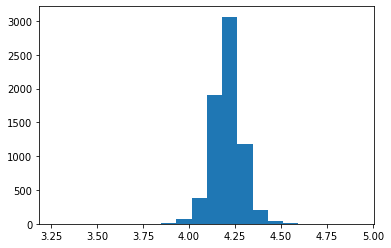

In [169]:
plt.hist(preds, bins=20);

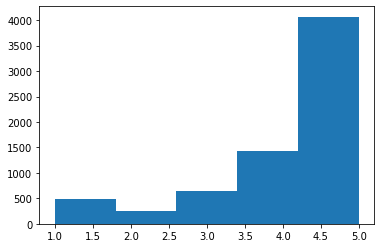

In [145]:
plt.hist(df.rating, bins=5);